# Spatial join

Spatial join is yet another classic GIS task. Retrieving table attributes from one layer and transferring them into another layer based on their spatial relationship is something you most likely need to do on a regular basis when working with geographic data. In the previous section, you learned how to perform spatial queries, such as investigating if a Point is located within a Polygon. We can use this same logic to conduct a spatial join between two layers based on their spatial relationship and transfer the information stored in one layer into the other. We could, for example, join the attributes of a polygon layer into a point layer where each point would get the attributes of a polygon that `intersects` with the point. 

## The basic logic of spatial join

In Figure 6.40, we illustrate the logic of a spatial join by showing how it is possible to combine information between spatial data layers that are located in the same area (i.e. they overlap with each other at least partially). The target here is to combine attribute information of three layers: properties, land use and buildings. Each of these three layers has their own attribute information. Transfering the information between the layers is based on how the individual points in the Properties layer intersect with these layers as shown on the left, i.e. considering different land use areas (commercial, residential, industrial, natural), as well as the building footprints containing a variety of building-related attibute information. On the right, we show the table attributes for these three layers considering the features that intersect with the four Point observations. The table at the bottom shows how the results look after all the attribute data from these layers has been combined into a single table. 

It is good to remember that spatial join is always conducted between two layers at a time. Hence, in practice, if we want to make a spatial join between these three layers shown in **Figure 6.37**, we first need to conduct the spatial join between Properties and Land use, and then store this information into an intermediate result. After the first join, we need to make another spatial join between the intermediate result and the third layer (here, the Buildings dataset). After these two separate spatial joins, we have achieved the final result shown at the bottom, showing for each property (row) the corresponding attributes from the land use and building layers as separate columns. In a similar manner, you could also continue joining data (attributes) from other layers as long as you need.  

![_**Figure 6.40**. Spatial join allows you to combine attribute information from multiple layers based on spatial relationship._](../img/spatial-join-basic-idea.png)

_**Figure 6.40**. Spatial join allows you to combine attribute information from multiple layers based on spatial relationship._


Now as we understand the basic idea behind the spatial join, let's continue to learn a bit more about the details of spatial join. Figure 6.41 illustrates how we can do a spatial join between Point and Polygon layers, and how changing specific parameters in the way the join is conducted influence the results. In spatial join, there are two set of options that you can control, which ultimately influence how the data is transferred between the layers. You can control: 

1) How the spatial relationship between geometries should be checked (i.e. spatial predicates), and
2) What type of table join you want to conduct (inner, left, or right outer join)

The spatial predicates control how the spatial relationship between the geometries in the two data layers is checked. Only those cases where the spatial predicate returns `True` will be kept in the result. Thus, changing this option (parameter) can have a big influence on your final results after the join. In Figure 6.41 this difference is illustrated at the bottom when you compare the result tables *i* and *ii*: In the first table (*i*) the spatial predicate is `within` that gives us 4 rows that is shown in the table. However, on the second result table (*ii*), the spatial predicate `intersects` gives us 5 rows. Why is there a difference? This is because the Point with id-number 6 happens to lie exactly at the border of the Polygon C. As you might remember from the  Chapter 6.6, there is a certain difference between these two spatial predicates: The `within` predicate expects that the Point should be inside the Polygon (`False` in our case), whereas `intersects` returns `True` if at least one point is common between the geometries (`True` in our case). In a similar manner, you could change the spatial predicate to `contains`, `touches`, `overlaps` etc. and the result would change accordingly. 

It is also important to ensure that the logic for investigating these spatial relationships makes sense when deciding which spatial predicate to use. For example, it would not make any sense to check whether Layer 1 (points) contain the Layer 2 (polygons) because Point objects do not have an interior or boundary, thus lacking the ability to contain any geometric object. Doing this kind of spatial join is possible, but the result from this type of spatial join would always return an empty GeoDataFrame.  However, if we change the spatial join criteria and join the data between layers if the Layer 2 (polygons) contain the Layer 1 (points), this would make a perfect sense, and the query would return rows that match with this criteria.   

![_**Figure 6.41**. Different approaches to join two data layers with each other based on spatial relationships._](../img/spatial-join-alternatives.png)

_**Figure 6.41**. Different approaches to join two data layers with each other based on spatial relationships._

The other parameter that you can use to control how the spatial join is conducted is the spatial join type. There are three different join types that influence the outcome of the spatial join:

1. {term}`inner join`
2. {term}`left outer join`
3. {term}`right outer join`

The terms left and right correspond to the two data layers/tables used in the spatial join, and specifically to the order how these layers are used in the spatia join. In our case, the Layer 1 represents always the `left` side of spatial join (indicated with green background color in the tables), whereas the Layer 2 corresponds to the `right` accordingly (white background). When looking at the result tables *i* and *ii* (Figure 6.41), we can see that both spatial joins have been conducted using an `inner join`. When using the `inner join`, we only keep such rows from the right and left tables that have received `True` after testing the relationship based on the chosen spatial predicate. The result table *iii* shows an example of `left outer join` in which all the rows from the left are kept (no matter what), and the ones from the right that have a match based on spatial predicate will be added to the result. In case some of the rows on the left do not have a match with the right layer, those attributes will receive NaN (No data) as the attribute value as shown with Point id 3 and 6 in the result table *iii*. The `right outer join` works in quite a similar manner, but in this case the values on the right layer are always kept (no matter what), and only the ones from the left that have a match based on the spatial predicate will be kept. The rows without a match will receive a Nan (No data) on the left side as shown in result table *iv* with Polygon that has a Name D.  

With these two parameters (spatial predicate and join type), it is possible to conduct many kind of spatial joins. Commonly the `inner join` using the `intersect` as a spatial predicate is the one that you want to use, but depending on your needs there are various options where to choose from.

## Spatial join with Python

Now as we have learned the basic logic of spatial join, let's see how we can do it in Python. Spatial join can be done easily with geopandas using the `.sjoin()` method. Next, we will learn how to use this method to perform a spatial join between two layers: 1) `addresses` which are the locations that we geocoded in the Chapter 6.5, and 2) `population grid` which is a 250m x 250m grid polygon layer that contains population information from the Helsinki Region (source: Helsinki Region Environmental Services Authority). Let's start by reading the data:

In [1]:
import geopandas as gpd

addr_fp = "data/Helsinki/addresses.shp"
addresses = gpd.read_file(addr_fp)
addresses.head(2)

,address,id,addr,geometry
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (24.91556 60.1632)
1,"1, Kampinkuja, Kamppi, Eteläinen suurpiiri, He...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (24.93009 60.16846)


As we can see, the `addresses` GeoDataFrame contains address Points which represent a selection of public transport stations in the Helsinki Region.

In [2]:
pop_grid_fp = "data/Helsinki/Population_grid_2021_HSY.gpkg"
pop_grid = gpd.read_file(pop_grid_fp)
pop_grid.head(2)

,id,inhabitants,occupancy_rate,geometry
0,Vaestotietoruudukko_2021.1,5,50.60,"POLYGON ((25472499.995 6689749.005, 25472499.9..."
1,Vaestotietoruudukko_2021.2,7,36.71,"POLYGON ((25472499.995 6685998.998, 25472499.9..."


The `pop_grid` dataset contains few columns, namely a unique `id`, the number of `inhabitants` per grid cell, and the `occupancy_rate` as percentage. 

### Preparations for spatial join

As a first step before making a spatial join, it is always good to check that the coordinate reference system (CRS) of the layers are identical. The basic requirement for a successful spatial join is that the layers should overlap with each other in space. If the geometries between the layers do not share the same CRS, it is very likely that the spatial join will fail and produces an empty GeoDataFrame. By looking at the numbers in the `geometry` column of the `addresses` and `pop_grid` GeoDataFrames above, it is fairly evident that the datasets are in different coordinate reference system as the numbers seem to differ a lot. Let's check the CRS information of each layer:

In [3]:
print("Address points CRS:", addresses.crs.name)
print("Population grid CRS:", pop_grid.crs.name)

Adress points CRS: WGS 84
Population grid CRS: ETRS89 / GK25FIN


We can further verify that the crs are indeed not the same. 

In [4]:
addresses.crs == pop_grid.crs

False

To fix this issue, let's reproject the geometries in the `addresses` GeoDataFrame to the same CRS as `pop_grid` using the `.to_crs()` method which was introduced in Chapter 6.4. To ensure that we will have exactly the same CRS in both layers, we can use the `pop_grid.crs` attribute information as the input for the `crs` parameter:

In [5]:
# Reproject
addresses = addresses.to_crs(crs=pop_grid.crs)

# Validate match
addresses.crs == pop_grid.crs

True

Good, now the datasets share the same coordinate reference system. As a last preparatory step, let's visualize both datasets on top of each other to see how the inhabitants are distributed over the region, and how the address points are located in relation to the grid:

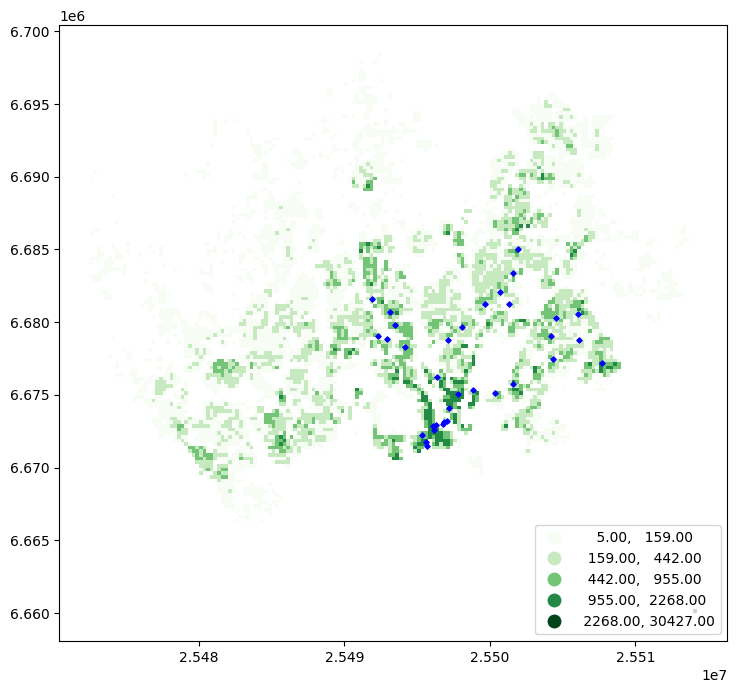

In [6]:
# Plot the population data classified into 5 classes
ax = pop_grid.plot(
    column="inhabitants",
    cmap="Greens",
    scheme="naturalbreaks",
    k=5,
    legend=True,
    legend_kwds={"loc": "lower right"},
    figsize=(10, 8),
)

# Add address points on top using blue "Diamond" markers
ax = addresses.plot(ax=ax, color="blue", markersize=7, marker="D")

_**Figure 6.42**. Prerequisite for a successful spatial join: The Polygon layer overlaps with the Point layer._

As we can see from the map in Figure 6.42, the Polygons representing the population distribution in the area now overlap nicely with the address locations and we are ready to join information among these two layers based on their spatial relationship.   

In [7]:
# This cell sets the number of lines of pandas output to a maximum of 7
# The cell is removed when building the website/book PDF
import pandas as pd

pd.set_option("display.max_rows", 7)

### Join the layers based on spatial relationship

After the preparatory steps, we are ready to perform the spatial join between our two data layers. The aim here is to get information about *How many people live in a given polygon that contains an individual address-point*? Thus, we want to join the attribute information from the `pop_grid` layer into the `addresses` Point layer using the `.sjoin()` method. As we saw in the beginning of Chapter 6.7, there are different ways to conduct spatial join by adjusting the {term}`spatial predicate` and join-type options. Controlling the spatial predicate in the `.sjoin()` can be done using the `predicate` parameter. The most commonly used options for the `predicate` parameter are:

- "intersects" (the default option)
- "contains"
- "covered_by"
- "covers"
- "crosses"
- "overlaps"
- "touches"
- "within'

The join type, as we learned earlier, is the second option to control how the data will be merged. In `.sjoin()` method, this can be adjusted with the `how` parameter. The possible values for the `how` parameter are:

- `"inner"` (the default option)
- `"left"`
- `"right"`

Let's now join the attributes from the `pop_grid` GeoDataFrame into the `addresses` GeoDataFrame by using the `.sjoin()`. Here, the `addresses` GeoDataFrame containing the points is the one we want to use as a starting point, as this layer is the *receiving* member of the spatial join. Futhermore, we specify `predicate="within"` for the spatial predicate as we are interested to know *within* which Polygon a given Point is located. Finally, we specify the join type with `how="inner"` which means that only such rows are kept from both layers where the spatial predicate returns `True`. This means that if there are Points that are not inside of any of the Polygons, they will be dropped from the result. Thus, we formulate the command in the following form and store the result in the variable `join`:

In [8]:
join = addresses.sjoin(pop_grid, predicate="within", how="inner")
join

,address,id_left,addr,geometry,index_right,id_right,inhabitants,occupancy_rate
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),3262,Vaestotietoruudukko_2021.3263,505,14.01
1,"1, Kampinkuja, Kamppi, Eteläinen suurpiiri, He...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496118.86 6672844.074),3381,Vaestotietoruudukko_2021.3382,172,27.67
2,"Espresso House, 8, Kaivokatu, Keskusta, Kluuvi...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (25496754.115 6673032.35),3504,Vaestotietoruudukko_2021.3505,43,61.44
...,...,...,...,...,...,...,...,...
31,"Ruoholahdenkatu, Kamppi, Eteläinen suurpiiri, ...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (25496135.452 6672615.098),3382,Vaestotietoruudukko_2021.3383,1409,32.37
32,"3, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (25495624.409 6671766.187),3309,Vaestotietoruudukko_2021.3310,995,37.07
33,"Oluthuone Kaisla, 4, Vilhonkatu, Kaisaniemi, K...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (25497062.747 6673226.621),3555,Vaestotietoruudukko_2021.3556,281,36.14


Awesome! Now we have performed a successful spatial join that gave us as a result 31 rows and four new columns. Most importantly, we received information about `inhabitants` and `occupancy_rate` which correspond to the number of inhabitants and occupancy rate in the cell where the address-point is located. In addition, we got columns `index_right` and `id_right` which tell the index and id of the matching polygon in the right-side member of the spatial join (i.e. population grid). As you see, also the `id` column in the left-side member of the spatial join was renamed as `id_left`. The suffices `_left` and `_right` are appended to the column names to differentiate the columns in cases where there are identical column names present in both GeoDataFrames. 

Let's also visualize the joined output. In the following, we plot the points using the `inhabitants` column to indicate the color:

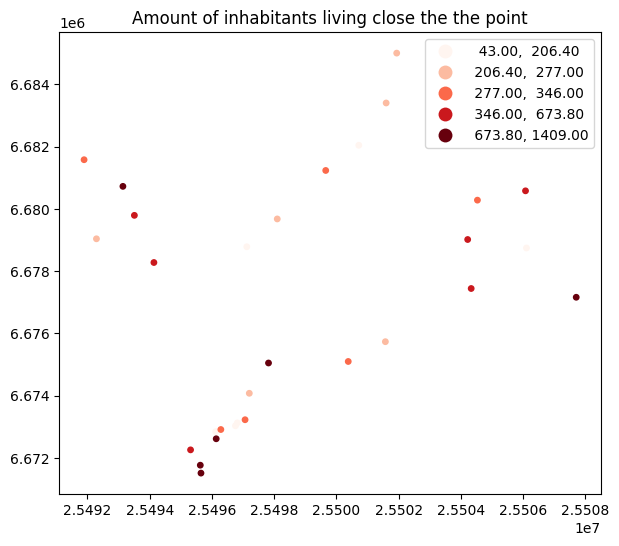

In [9]:
ax = join.plot(
    column="inhabitants",
    cmap="Reds",
    markersize=15,
    scheme="quantiles",
    legend=True,
    figsize=(10, 6),
)
ax.set_title("Amount of inhabitants living close to the point");

_**Figure 6.43**. Amount of population living close to the addresses can be visualized after a successful spatial join with the population grid._

As we see from the map, the number of population living close to the stations vary quite significantly ranging from 43 up to 1409 inhabitants. As a last thing after the spatial join, it is useful to investigate if we lost any data while doing the spatial join. Let's check this by comparing the number of rows in our result to how many addresses we had originally:

In [10]:
len(addresses) - len(join)

4

As we can see, there seems to be three Points that were located outside of the populated grid cells. If we plot the layers on top of each other as an interactive map, we can investigate where the points outside of polygons are located:

In [11]:
m = pop_grid.explore(color="blue", style_kwds=dict(color="blue", stroke=False))
addresses.explore(m=m, color="red")

_**Figure 6.44**. An interactive map of the two layers reveal that some points are located outside of the Polygons._

From **Figure 6.44**, we can see that some points are located outside of polygons in the areas close to the railway lines and the motorway. Is this a problem? It depends, but in certain cases, you might want to keep the information for the points that did not get a match based on the spatial relationship. We can achieve this by changing the `how` parameter into `left`, which keeps every row from the left member of the spatial join even when no match is found from the other layer:

In [12]:
# This cell sets the number of lines of pandas output to a maximum of 7
# The cell is removed when building the website/book PDF
pd.set_option("display.max_rows", 7)

In [13]:
left_join = addresses.sjoin(pop_grid, predicate="within", how="left")
left_join

,address,id_left,addr,geometry,index_right,id_right,inhabitants,occupancy_rate
0,"Ruoholahti, 14, Itämerenkatu, Ruoholahti, Läns...",1000,"Itämerenkatu 14, 00101 Helsinki, Finland",POINT (25495311.608 6672258.695),3262.0,Vaestotietoruudukko_2021.3263,505.0,14.01
1,"1, Kampinkuja, Kamppi, Eteläinen suurpiiri, He...",1001,"Kampinkuja 1, 00100 Helsinki, Finland",POINT (25496118.86 6672844.074),3381.0,Vaestotietoruudukko_2021.3382,172.0,27.67
2,"Espresso House, 8, Kaivokatu, Keskusta, Kluuvi...",1002,"Kaivokatu 8, 00101 Helsinki, Finland",POINT (25496754.115 6673032.35),3504.0,Vaestotietoruudukko_2021.3505,43.0,61.44
...,...,...,...,...,...,...,...,...
31,"Ruoholahdenkatu, Kamppi, Eteläinen suurpiiri, ...",1032,"Ruoholahdenkatu 17, 00101 Helsinki, Finland",POINT (25496135.452 6672615.098),3382.0,Vaestotietoruudukko_2021.3383,1409.0,32.37
32,"3, Tyynenmerenkatu, Jätkäsaari, Länsisatama, E...",1033,"Tyynenmerenkatu 3, 00220 Helsinki, Finland",POINT (25495624.409 6671766.187),3309.0,Vaestotietoruudukko_2021.3310,995.0,37.07
33,"Oluthuone Kaisla, 4, Vilhonkatu, Kaisaniemi, K...",1034,"Vilhonkatu 4, 00101 Helsinki, Finland",POINT (25497062.747 6673226.621),3555.0,Vaestotietoruudukko_2021.3556,281.0,36.14


Now the result in the `left_join` contains all the original 34 addresses. Let's investigate a bit more to see which rows did not have a matching polygon in the population grid. After a left-join, those rows that do not have a matching geometry in the right-side member of the join are filled with NaN values. Thus, we should be able to locate them easily by searching for rows that do not have any values e.g. in the `inhabitants` column that was part of the `pop_grid` GeoDataFrame. We can do this by doing a selection using the `.isnull()` method:

In [14]:
left_join.loc[left_join["inhabitants"].isnull()]

,address,id_left,addr,geometry,index_right,id_right,inhabitants,occupancy_rate
3,"Hermannin rantatie, Verkkosaari, Kalasatama, S...",1003,"Hermannin rantatie 1, 00580 Helsinki, Finland",POINT (25498818.232 6675344.766),NaN,NaN,NaN,NaN
9,"5, Atomitie, Strömberg, Pitäjänmäen teollisuus...",1010,"Atomitie 5, 00370 Helsinki, Finland",POINT (25492904.054 6678862.586),NaN,NaN,NaN,NaN
18,"6, Ratapihantie, Itä-Pasila, Pasila, Keskinen ...",1019,"Ratapihantie 6, 00101 Helsinki, Finland",POINT (25496358.8 6676198.28),NaN,NaN,NaN,NaN
21,"Tattariharjuntie, Sepänmäki, Ala-Malmi, Malmi,...",1022,"Tattariharjuntie, 00700 Helsinki, Finland",POINT (25501297.473 6681256.638),NaN,NaN,NaN,NaN


The result from this query reveals the exact locations of the points that miss information in the last four columns of the GeoDataFrame. Okay, but is this all we can do? In some cases, it can be crucial that all features in the target layer would get information from the other dataset even if the spatial predicate between the geometries would not match perfectly. Sometimes fetching information from another layer based on the closest geometry up to a certain distance threshold can be considered sufficient for making a spatial join. Luckily, we can achieve this with relative ease using geopandas which we will learn next.

#### Question 6.10

Do the spatial join another way around, i.e. make a spatial join where you join information from the address points into the population grid. How does the result differ from the version where we joined information from the grids to the points? What would be the benefit of doing the join this way around?

In [15]:
# You can use this cell to enter your solution.

In [16]:
# Solution

# Join information from address points to the grid
result = pop_grid.sjoin(addresses)

# Check the structure
print(result.head(2))

# Visualize the result
result.explore()

# see reflection about this solution in the back matter

                            id_left  inhabitants  occupancy_rate  \
2605  Vaestotietoruudukko_2021.2606          319           38.07   
2723  Vaestotietoruudukko_2021.2724          231           33.98   

                                               geometry  index_right  \
2605  POLYGON ((25491749.995 6681499.004, 25491749.9...           16   
2723  POLYGON ((25492249.999 6678999.002, 25492249.9...           19   

                                                address  id_right  \
2605  Malminkartanontie, Malminkartano, Kaarela, Län...      1017   
2723  Pizza Benitto, 15, Pitäjänmäentie, Reimarla, P...      1020   

                                               addr  
2605  Malminkartanontie 17, 00410 Helsinki, Finland  
2723     Pitäjänmäentie 15, 00370 Helsinki, Finland  
